<a href="https://colab.research.google.com/github/elijahmoon-hub/Elijah-s-repository/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 1)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 1)
    mu_nu = pm.Exponential('mu_nu',lam=1/30)
    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  nu = mu_nu, # Added nu parameter for StudentT prior
                  dims = "aa")


    σ = pm.HalfStudentT('σ', sigma = 10,
                      nu = 30, # Added nu parameter for HalfStudentT prior
                      dims = "aa")
    v = pm.Exponential('nu',lam=1/30)
    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  nu = v, # Added nu parameter for StudentT likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

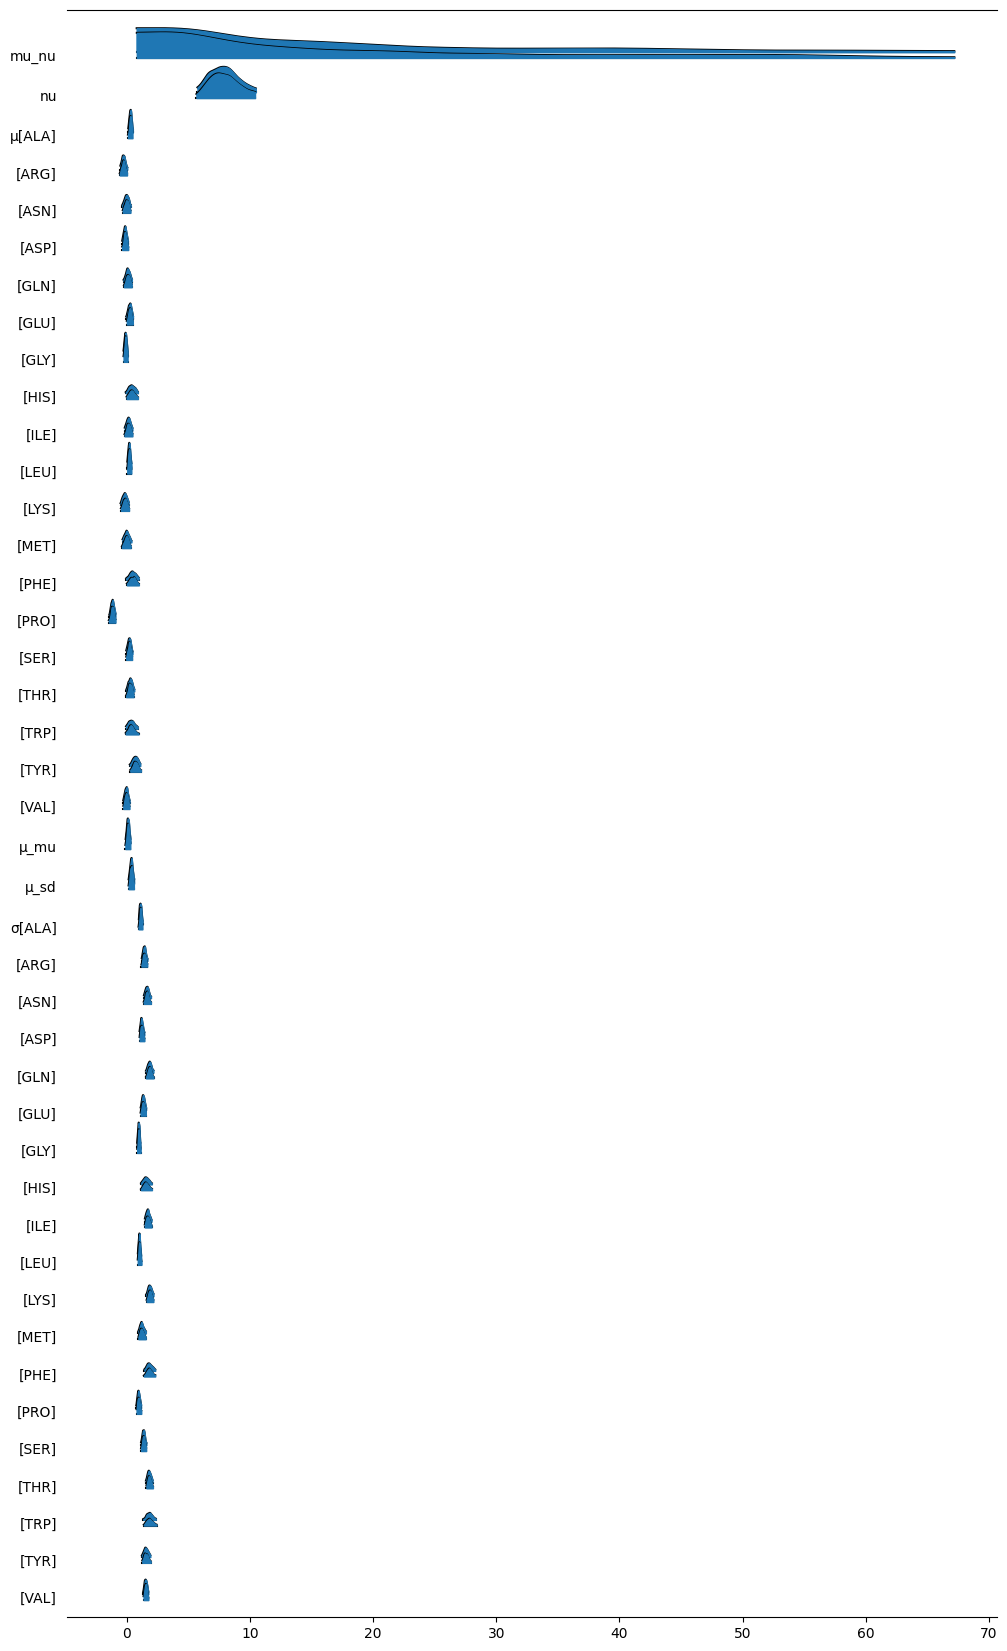

In [5]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot")

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
# Perform posterior predictive check for the Student T hierarchical model
with cs_h_model:
    pm.sample_posterior_predictive(idata_cs_h, extend_inferencedata=True)

(-10.0, 10.0)

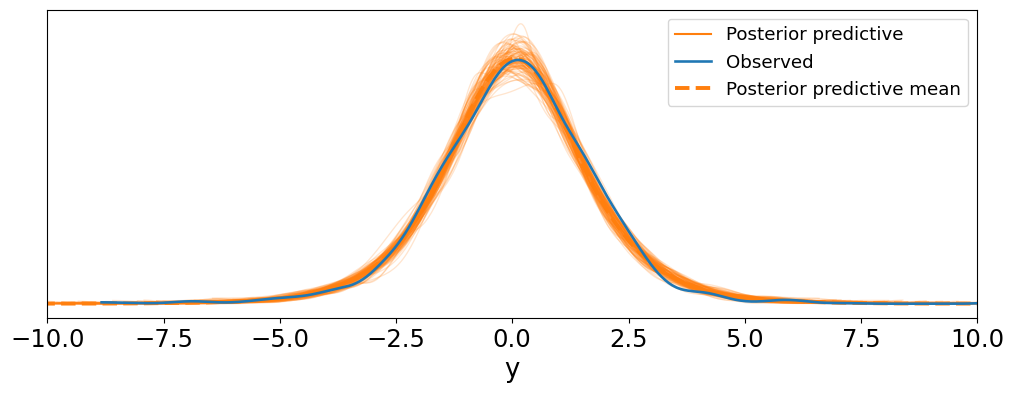

In [7]:
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [8]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [9]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    # The sampling process was interrupted (KeyboardInterrupt).
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

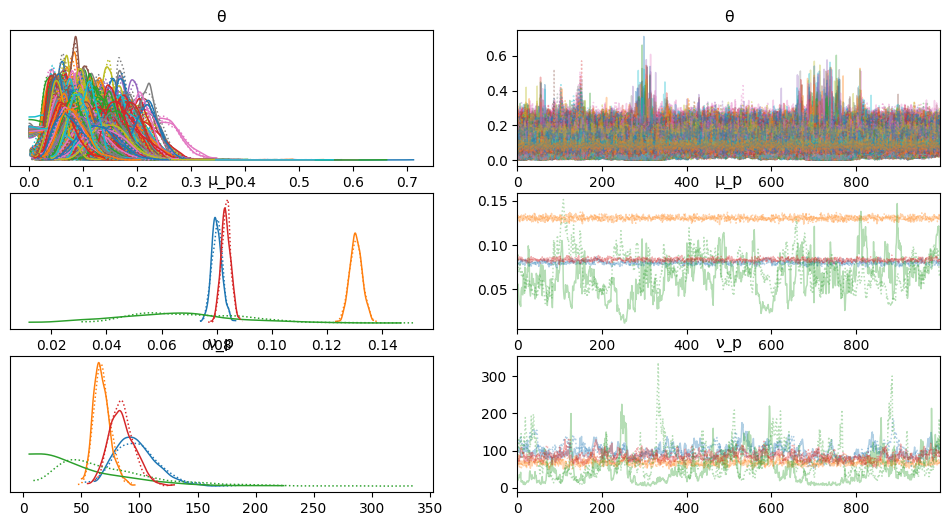

In [12]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

In [ ]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr)

In the μ_p plot, the non heirarchical model has a larger range, from 0-0.18 on the x axis. In the heirarchical model, the range only goes from 0-0.14. However, the y axis of the heirarchical model is more compressed than the y axis of the other model. In the plots of θ, the x and y axis are the same in both but non heirarchical model has higher peaks as x goes past 800. The R hat values in the heirarchical models have values above 1.1 which is not good. However, all R hat values on this model are less than 1.1.



**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Text(0.5, 1.0, 'Messi mean')

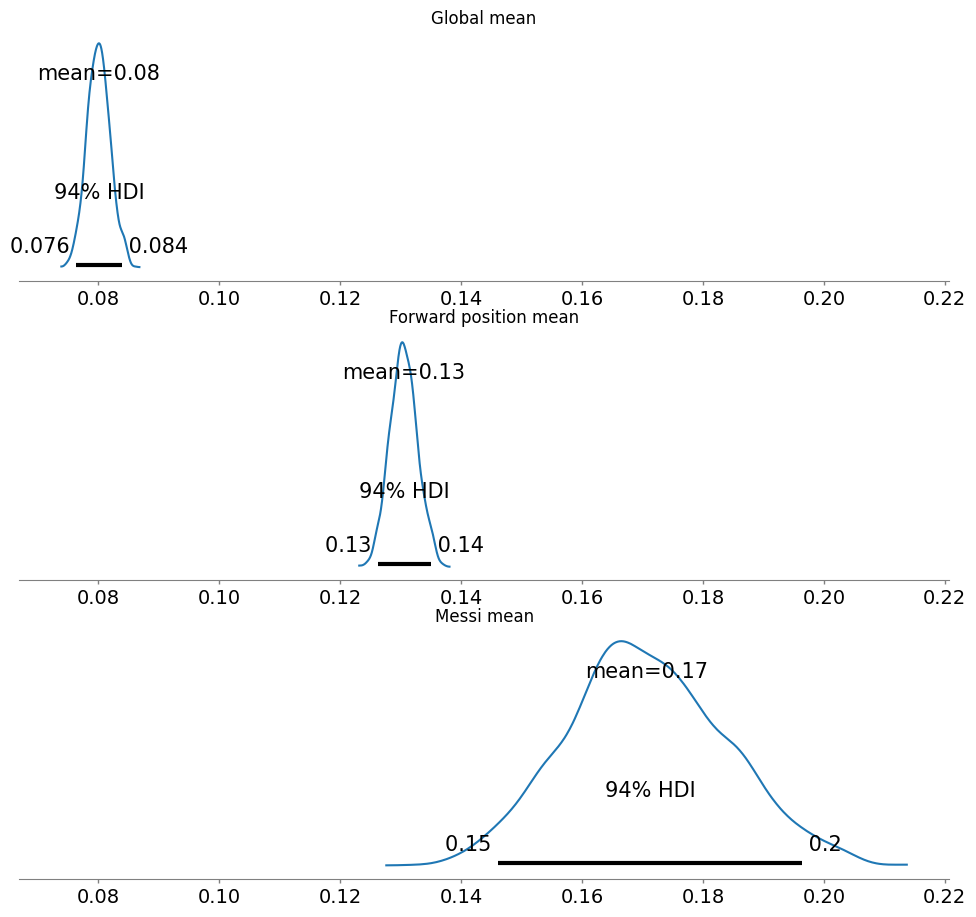

In [14]:
#preps a plot object to have three seperate plots, all with the same x axis
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)

#plot the overall mean shooting percentage
az.plot_posterior(idata_sccr, var_names="μ_p", ax=ax[0])
ax[0].set_title(r"Global mean")

#plot the fowrads shooting percentage
az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names="μ_p", ax=ax[1])
ax[1].set_title(r"Forward position mean")

#plot Linonel Messi's shooting pecentage
az.plot_posterior(idata_sccr.posterior.sel(θ_dim_0=1457), var_names="θ", ax=ax[2])
ax[2].set_title(r"Messi mean")

The Posterior for the non heirarchical model gives us a similar mean as the other model with a mean of 0.08 compared to 0.092. However, the highest density interval in the non heirarchical model is much smaller and gives us a more specific range of the mean, from 0.076 to 0.084. This smaller range allows to better predict the mean. The heirarchical model has an HDI from 0.056 to .13 which is a lot larger, leaving a lot more space for error. The forward position mean is exactly the same in both models. In the posterior of the Messi mean, the mean is the same in both models again. However, the range of the hdi is slightly different, with a range of .14-.19 compared to .15-.19.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [15]:
sccr_data_nogk = sccr_data[sccr_data['position'] == "GK"]

In [16]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data_nogk = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

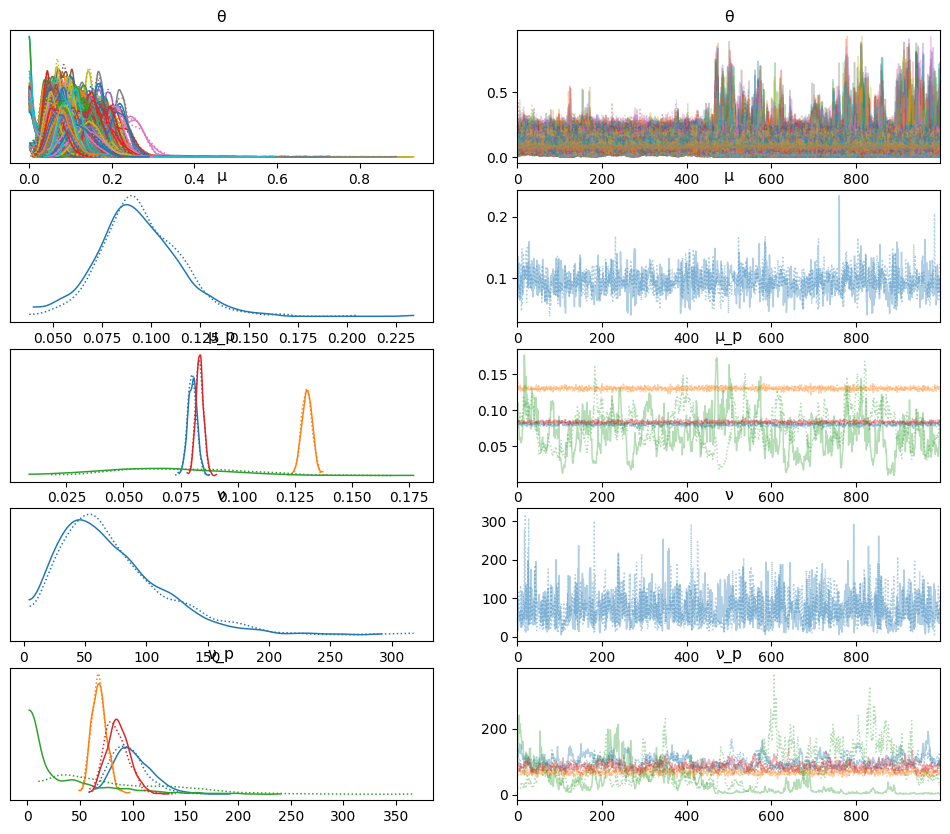

In [27]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The model with the goalkeepers was easier for pymc to process compared to the data after removing the goalkeepers. From dropping the Gks, we gain more accurate data that better illustrates the values that we're predicting from. Because the data shows the players and the shots they've taken and goals they've made. But, goalkeepers almost never take shots on goal and scoring as a Gk is very rare. This creates a discrepancy in the data and doesn't illustrate what we're trying to find as well.